<a href="https://colab.research.google.com/github/btlgs2000/dl_intro/blob/master/keras_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layer

In [54]:
from tensorflow.keras.layers import Dense, Layer, BatchNormalization, Dropout
from keras import Sequential, Model, Input
import tensorflow.keras as keras

import numpy as np

In [ ]:
dense = Dense(10)

In [ ]:
bn = BatchNormalization()

In [ ]:
isinstance(dense, Layer)

In [ ]:
# importante! settando questo attributo a False i suoi pesi non vengono aggiornati col gradient descent
dense.trainable

In [ ]:
dense.variables

In [ ]:
dense.name

In [ ]:
dense.input

In [ ]:
dense.output

In [34]:
# inizializzazione dei pesi tramite build

In [ ]:
dense = Dense(10)

In [ ]:
dense.build((100,))

In [ ]:
dense.trainable_variables

In [ ]:
# settare l'inizializzazione

In [ ]:
dense = Dense(10, kernel_initializer='glorot_normal')

In [ ]:
dense = Dense(10, kernel_initializer=keras.initializers.GlorotNormal(seed=1))

In [ ]:
# inizializzazione mediante call

In [35]:
dense = Dense(10)

In [37]:
dense(np.random.rand(10, 45))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[-1.645185  , -0.5009559 , -0.06317981, -0.24400616,  0.90393156,
        -0.7972266 , -0.43785754, -0.28250152,  0.24006838, -0.12910067],
       [-1.1033454 , -0.3457085 ,  0.1081899 , -0.23529917,  0.88349146,
        -0.23539732, -0.31866154, -0.01469169,  0.781118  , -0.33985212],
       [-1.7388703 ,  0.18508257, -0.49982676, -0.26958054,  0.9675404 ,
         0.04701215, -0.33706328,  0.04611036,  0.8343475 , -0.26132834],
       [-0.20337819, -0.51118785,  0.09158083, -0.6669274 ,  0.87088275,
        -0.52905905, -0.3351609 , -0.32340953,  0.33571944,  0.33990195],
       [-0.85445565, -0.37427318, -0.33322722, -0.45912945,  0.78990537,
        -0.56181264, -0.17230752, -0.4619158 ,  0.467419  , -0.3378776 ],
       [-1.0231018 ,  0.5769717 ,  0.65387005, -0.89226294,  0.91819227,
        -0.38955444,  0.37490755,  0.2800182 ,  0.5983208 ,  0.5582921 ],
       [-1.3789853 , -0.569414  , -0.7651389 , -0.93493587,  0.55517

In [39]:
bn(np.random.rand(10, 45))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(10, 45), dtype=float32, numpy=
array([[0.9320059 , 0.2213134 , 0.9398596 , 0.53163075, 0.3842721 ,
        0.43567276, 0.34435776, 0.12215943, 0.7674264 , 0.46095878,
        0.05627105, 0.8063271 , 0.23450154, 0.630563  , 0.73475903,
        0.7268912 , 0.5857646 , 0.90726024, 0.37331387, 0.849407  ,
        0.50986904, 0.46782112, 0.8935989 , 0.3637813 , 0.0469293 ,
        0.00513168, 0.28755817, 0.13052168, 0.5855152 , 0.51339406,
        0.44864509, 0.8085172 , 0.12698852, 0.7746525 , 0.5337084 ,
        0.7368198 , 0.7277293 , 0.3352553 , 0.5867963 , 0.30069917,
        0.06538653, 0.4265731 , 0.13861664, 0.32494926, 0.9331802 ],
       [0.40246242, 0.8197028 , 0.14479612, 0.05436074, 0.47777355,
        0.69922864, 0.05961046, 0.6452895 , 0.325733  , 0.29601735,
        0.23512594, 0.60767275, 0.621465  , 0.91566473, 0.7824096 ,
        0.649083  , 0.54672277, 0.71189845, 0.38720196, 0.23863122,
        0.90426046, 0.61492175, 0.01066813, 0.8198625 , 0.1514386

In [42]:
bn.weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(45,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(45,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_mean:0' shape=(45,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_variance:0' shape=(45,) dtype=float32, numpy=
 array(

In [43]:
bn.trainable_weights

[<tf.Variable 'batch_normalization/gamma:0' shape=(45,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>,
 <tf.Variable 'batch_normalization/beta:0' shape=(45,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [44]:
bn.non_trainable_weights

[<tf.Variable 'batch_normalization/moving_mean:0' shape=(45,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'batch_normalization/moving_variance:0' shape=(45,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>]

# Modelli

## Sequenziale

In [76]:
# Posso specificare un input con il parametro input_shape del primo layer
# oppure includendo all'inizio un oggetto di tipo Input

model = Sequential(
    [
     Input(10),
     Dense(10, activation='relu', name='dense_1'),
     Dropout(0.1, name='dropout_1'),
     Dense(10, activation='relu', name='dense_2'),
     Dropout(0.1, name='dropout_2'),
     Dense(1, name='output')
    ]
)

In [77]:
isinstance(model, Model)

True

In [78]:
isinstance(model, Layer)

True

In [79]:
model.layers

In [80]:
dense_1 = model.get_layer(name='dense_1')

In [81]:
dense_1.output

<tf.Tensor 'dense_1/Relu_2:0' shape=(None, 10) dtype=float32>

In [82]:
dense_1.input

<tf.Tensor 'input_2:0' shape=(None, 10) dtype=float32>

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


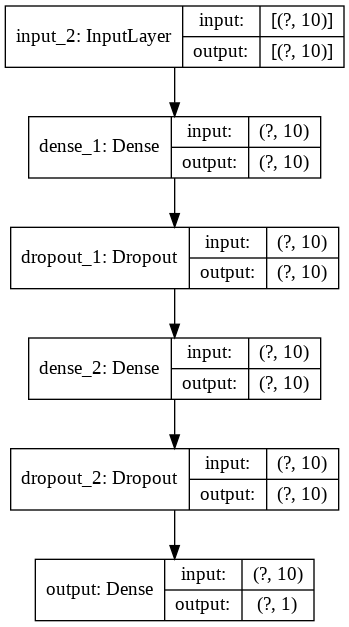

In [85]:
keras.utils.plot_model(model=model, show_shapes=True)